In [3]:
# paquetes de la implementación
import numpy as np
import ale_py # ambiente de Breakout
import gymnasium as gym
import random

# paquetes de las gráficas
import matplotlib.pyplot as plt
import cv2

In [4]:
# entorno 
env = gym.make('ALE/Breakout-v5')

In [5]:
# hiperparámetros
alpha = 0.1         # tasa de aprendizaje
gamma = 0.995       # descuento
epsilon = 0.1       # epsilon
n_planning = 50     # planeación
num_episodios = 1500

num_acciones = env.action_space.n 

pasos_totales = 0
lista_pasos = []         
lista_recompensas = []

In [6]:
def discreto(obs):
    """
    Como Breakout es tiene un espacio de obs continuo
    es necesario discretizar el espacio RGB
    """
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    small = cv2.resize(gray, (16, 16), interpolation=cv2.INTER_AREA)
    binary = (small > 128).astype(np.uint8)
    return binary

In [7]:
def get_state_key(obs):
    procesado = discreto(obs)
    return tuple(procesado.flatten())

In [8]:
# tabla Q
Q = {}
Model = {}

def get_Q(estado, accion):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    return Q[key]

def act_Q(estado, accion, td_error):
    key = (estado, accion)
    if key not in Q:
        Q[key] = 0.0
    Q[key] += alpha * td_error


In [9]:
# entrenamiento
for episodio in range(num_episodios):
    obs, info = env.reset()
    estado = get_state_key(obs)
    terminado = False
    recompensa_total = 0

    while not terminado:
        # política
        if np.random.rand() < epsilon:
            accion = np.random.randint(num_acciones)
        else:
            q_vals = [get_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
        
        
        next_obs, recompensa, terminated, trunco, info = env.step(accion)
        terminal = terminated or trunco
        pasos_totales += 1
        recompensa_total += recompensa
        next_estado = get_state_key(next_obs)

        best_next_q = max([get_Q(next_estado, a) for a in range(num_acciones)])
        td_error = recompensa + gamma * best_next_q - get_Q(estado, accion)
        act_Q(estado, accion, td_error)
    
        Model[(estado, accion)] = (recompensa, next_estado)
       
        if len(Model) > 0:
            for _ in range(n_planning):
                key_sim = random.choice(list(Model.keys()))
                r_sim, next_state_sim = Model[key_sim]
                a_sim = key_sim[1]
                best_next_q_sim = max([get_Q(next_state_sim, a) for a in range(num_acciones)])
                td_error_sim = r_sim + gamma * best_next_q_sim - get_Q(key_sim[0], a_sim)
                act_Q(key_sim[0], a_sim, td_error_sim)
        
        estado = next_estado
        terminado = terminal

    lista_recompensas.append(recompensa_total)
    lista_pasos.append(pasos_totales)
    
    if (episodio + 1) % 100 == 0:
        print(f"Episodio {episodio+1}, Recompensa = {recompensa_total}")

env.close()

Episodio 100, Recompensa = 1.0
Episodio 200, Recompensa = 1.0
Episodio 300, Recompensa = 0.0
Episodio 400, Recompensa = 0.0
Episodio 500, Recompensa = 1.0
Episodio 600, Recompensa = 3.0
Episodio 700, Recompensa = 0.0
Episodio 800, Recompensa = 4.0
Episodio 900, Recompensa = 0.0
Episodio 1000, Recompensa = 1.0
Episodio 1100, Recompensa = 2.0
Episodio 1200, Recompensa = 0.0
Episodio 1300, Recompensa = 3.0
Episodio 1400, Recompensa = 1.0
Episodio 1500, Recompensa = 2.0


In [10]:
def promedio(datos, vnv=10): # vnv: para el promedio de los episodios
    return np.convolve(datos, np.ones(vnv)/vnv, mode='valid')

vnv = 10
recompensas_soft = promedio(lista_recompensas, vnv)
pasos_soft = lista_pasos[vnv-1:] 

Gráfica de recompensa obtenida.
Eje x: pasos
Eje y : recompensa promedio


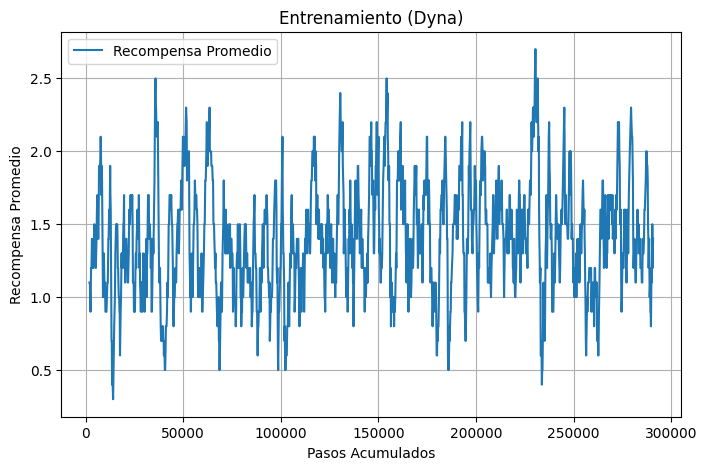

In [11]:
print("Gráfica de recompensa obtenida.")
print("Eje x: pasos")
print("Eje y : recompensa promedio")
plt.figure(figsize=(8,5))
plt.plot(pasos_soft, recompensas_soft, label=f"Recompensa Promedio")
plt.xlabel("Pasos Acumulados")
plt.ylabel("Recompensa Promedio")
plt.title("Entrenamiento (Dyna)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
def eva_politica(env, Q, n_episodios=10):
    recompensas = []
    for _ in range(n_episodios):
        obs, info = env.reset()
        estado = get_state_key(obs)
        terminado = False
        recompensa_total = 0
        while not terminado:
            q_vals = [get_Q(estado, a) for a in range(num_acciones)]
            accion = int(np.argmax(q_vals))
            next_obs, recompensa, terminated, trunco, info = env.step(accion)
            terminal = terminated or trunco
            recompensa_total += recompensa
            estado = get_state_key(next_obs)
            terminado = terminal
        recompensas.append(recompensa_total)
    return recompensas



In [13]:
# nuevo entorno para evaluación 
env_eval = gym.make('ALE/Breakout-v5')
recompensas_eval = eva_politica(env_eval, Q, n_episodios=10)
env_eval.close()

media_recompensa = np.mean(recompensas_eval)
std_recompensa = np.std(recompensas_eval)

print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {std_recompensa:<20.2f} |")
print("----------------------------------------------")


Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | 0.00                 |
| Desviación   | 0.00                 |
----------------------------------------------
